# 【問題1】SVM分類器のクラスを作成する

====================================================================================================<br>
分類のためのサポートベクターマシン（SVM、サポートベクトルマシン）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


SVMには学習時に分類の間違いを認めるソフトマージンSVMと、認めないハードマージンSVMがありますが、ここでは実装が単純なハードマージンSVMを扱います。


以下に雛形を用意してあります。このScratchSVMClassifierクラスにコードを書き加えていってください。

====================================================================================================<br>

## [ラグランジュの未定乗数法による最急降下]

SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 $\lambda$ を用意して、

以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。


## $$
\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})
$$

ここで $k(x_i, x_j)$ はカーネル関数です。線形カーネルの場合は次のようになります。

他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。

## $$
k(x_i, x_j) = x_{i}^{T} x_j
$$

条件として、更新毎に $\lambda_i >= 0$を満たす必要があります。満たさない場合は $\lambda_i = 0$とします。

$i, j$ : サンプルのインデックス<br>
$\lambda_i^{new}$ : 更新後のi番目のサンプルのラグランジュ乗数<br>
$\lambda_i$ : 更新前のi番目のサンプルのラグランジュ乗数<br>
$\alpha$ : 学習率<br>
$\lambda_j$ : j番目のサンプルのラグランジュ乗数<br>
$y_i$ : i番目のサンプルのラベル<br>
$y_j$ : j番目のサンプルのラベル<br>
$x_i$ : i番目のサンプルの特徴量ベクトル<br>
$x_j$ : j番目のサンプルの特徴量ベクトル<br>

あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。
====================================================================================================<br>

# 【問題2】サポートベクターの決定

====================================================================================================<br>
計算したラグランジュ乗数 $\lambda$ が設定した閾値より大きいサンプルをサポートベクターとして扱います。

推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。

閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。

サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

====================================================================================================<br>

# 【問題3】推定

====================================================================================================<br>

推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた $f(x)$ の符号が分類結果です。
## $$
y(x) = \sum_{n=1}^{N}\lambda_n y_n k(x, s_n)
$$

$x$ : 推定したいデータの特徴量ベクトル


$N$ : サポートベクターの数


$n$ : サポートベクターのインデックス


$\lambda_n$ : $n$番目のサポートベクターのラグランジュ乗数


$y_{sv_n}$ : $n$番目のサポートベクターのラベル


$k()$ : カーネル関数


$s_n$ : $n$番目のサポートベクターの特徴量

====================================================================================================<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
#データセット
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

#訓練・検証データに分割
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,stratify=y)


In [3]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    """

    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5,lam=5,verbose=False,gamma=1,theta=1,degree=1):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.lam_sv = lam
        self.gamma = gamma
        self.theta = theta
        self.degree = degree
        
    
    #カーネル関数を作成
    def kernel_func(self,X_i,X_j):
        if self.kernel == "linear":
            kernel_form = X_i@X_j.T
        
        elif self.kernel == "poly":
            kernel_form = (self.gamma*X_i@X_j.T+self.theta)**self.degree
        
        return kernel_form
     
        
    #更新式を作成
    def _gradient(self,X,y):
        """
        ラグランジュの未定乗数法による最急降下法でパラメータを更新

           Parameters
            ----------
            X : 次の形のndarray, shape (n_samples, n_features)
                  正解データ
            y : 次の形のndarray, shape (n_samples, )
                  正解データ

            Returns
            -------
            self.lam_sv：次の形のndarray, shape　(n_features,1)
                 ラグランジュの未定乗数法による最急降下法で更新したパラメータ
        """
        kernel = self.kernel_func(X, X)

        self.lam += self.lr * (1 - y*np.dot((self.lam*y), kernel))
        
        #0未満は０を返す
        self.lam[self.lam < 0]=0

        return self.lam
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
        訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
        検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
        検証データの正解値
        """

        #λの初期値
        self.lam = np.random.normal(loc=0,scale=0.01,size=X.shape[0])

        #閾値を超えたλの数＝サポートベクトルの数を入れるリスト
        self.n_support_vectors_lst = []
        
        #λを更新
        for i in range(self.iter):
            self.lam = self._gradient(X,y)
            
            #サポートベクトルのインデックスを取得
            self.index_support_vectors = np.where(self.lam > self.threshold)[0]
            
            #サポートベクトルの数を取得
            self.n_support_vectors = len(np.where(self.index_support_vectors))
            #リストに格納
            self.n_support_vectors_lst.append(self.n_support_vectors)
        
            #サポートベクターの特徴量を取得
            self.X_sv = X[self.index_support_vectors]
            
            #サポートベクターの未定乗数を取得
            self.lam_sv = self.lam[self.index_support_vectors]
            
            #サポートベクターのラベルを取得
            self.y_sv =  y[self.index_support_vectors]
            
            #verboseをTrueにした際はサポートベクトルの数の推移を出力
            if self.verbose is True:
                print(len(np.where(self.index_support_vectors)[0]))

    
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        pred = (self.kernel_func(X,self.X_sv))@(self.lam_sv*self.y_sv)
        #求めた結果の符号が分類結果➡︎0未満は-1それ以外は１
        return np.where(pred>0,1,-1)

# 【問題4】学習と推定

====================================================================================================<br>

機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

====================================================================================================<br>

In [21]:
#スクラッチ
s_svm = ScratchSVMClassifier(num_iter=1000, lr=0.001, kernel='linear', threshold=1e-5,verbose=False)

s_svm.fit(X_train,y_train)


s_pred = s_svm.predict(X_test)

print("=========score===========")
print("accuracy_score:{:.2f}".format(accuracy_score(y_test,s_pred)))
print("precision_score:{:.2f}".format(precision_score(y_test,s_pred)))
print("recall_score:{:.2f}".format(recall_score(y_test,s_pred)))
print("f1_score:{:.2f}".format(f1_score(y_test,s_pred)))
print(confusion_matrix(y_test,s_pred))

=========score===========
accuracy_score:1.00
precision_score:1.00
recall_score:1.00
f1_score:1.00
[[63  0]
 [ 0 62]]


In [11]:
#sklearn
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train,y_train)
Y_pred = clf.predict(X_test)

print("=========score===========")
print("accuracy_score:{:.2f}".format(accuracy_score(y_test,Y_pred)))
print("precision_score:{:.2f}".format(precision_score(y_test,Y_pred)))
print("recall_score:{:.2f}".format(recall_score(y_test,Y_pred)))
print("f1_score:{:.2f}".format(f1_score(y_test,Y_pred)))
print(confusion_matrix(y_test,Y_pred))

=========score===========
accuracy_score:1.00
precision_score:1.00
recall_score:1.00
f1_score:1.00
[[63  0]
 [ 0 62]]


# 【問題5】決定領域の可視化
====================================================================================================<br>

決定領域を可視化してください。

====================================================================================================<br>


In [11]:
#week4で用いた決定領域可視化関数
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01,target_names=None, title='decision region', xlabel='xlabel', ylabel='ylabel'):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    plt.scatter(X_train[s_svm.index_support_vectors, 0], X_train[s_svm.index_support_vectors, 1], s=80, color='yellow',label=target_names[2], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

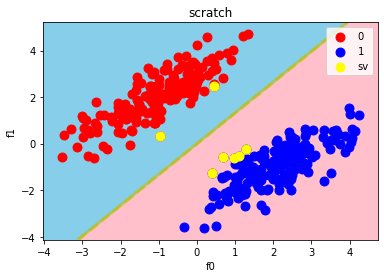

In [13]:
decision_region(X_train, y_train,s_svm, step=0.01, title='scratch', xlabel='f0', ylabel='f1', target_names=['0', '1','sv'])

# 【問題6】（アドバンス課題）多項式カーネル関数の作成

====================================================================================================<br>
問題1では線形カーネルを使用しましたが、多項式カーネルにも切り替えられるようにしましょう。


「線形カーネルの式」

## $$
k(x_i, x_j) = x_{i}^{T} x_j
$$

「多項式カーネルの式」

## $$
k(x_i, x_j) = \gamma(x_{i}^{T} x_j + \theta_0)^{d}
$$

$\gamma$, $\theta_0$, $d$ はハイパーパラメータです。


線形カーネルは $\gamma = 1$, $\theta_0 = 0$, $d = 1$の場合の多項式カーネルと等しいと言えます。

====================================================================================================<br>

In [19]:
s_svm = ScratchSVMClassifier(num_iter=1000, lr=0.001, kernel='poly', threshold=1e-5,verbose=False,gamma=1,theta=1,degree=1)

s_svm.fit(X_train,y_train)


s_pred = s_svm.predict(X_test)

print("=========score===========")
print("accuracy_score:{:.2f}".format(accuracy_score(y_test,s_pred)))
print("precision_score:{:.2f}".format(precision_score(y_test,s_pred)))
print("recall_score:{:.2f}".format(recall_score(y_test,s_pred)))
print("f1_score:{:.2f}".format(f1_score(y_test,s_pred)))
print(confusion_matrix(y_test,s_pred))


=========score===========
accuracy_score:1.00
precision_score:1.00
recall_score:1.00
f1_score:1.00
[[63  0]
 [ 0 62]]
